In [6]:
## Part 1: Wrangling
# Problem 1
import sqlite3
import pandas as pd
import numpy as np

from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Initiate db connection
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

# Create Team_Data table with win/lose percent
cursor.execute('DROP TABLE IF EXISTS Team_Data')
team_data_table_create = 'CREATE TABLE IF NOT EXISTS Team_Data AS SELECT yearID, teamID, lgID, franchID, G, W, L, ((CAST(G AS FLOAT(24)) - L)*100)/G as win_lose_percent FROM Teams'
cursor.execute(team_data_table_create)

# Load Team_Data into DF
team_data = pd.read_sql('SELECT yearID, teamID, lgID, franchID, G, W, L, win_lose_percent FROM Team_Data GROUP BY teamID, yearID', conn)

# Load Salary data into DF
salary_query = 'SELECT yearID, teamID, sum(salary) as total_payroll FROM Salaries GROUP BY yearID, teamID'
team_salaries = pd.read_sql(salary_query, conn)

cursor.close()
conn.close()

# Merge DFs
team_aggregate = team_data.merge(team_salaries, on=['yearID', 'teamID'])

#Describe how you dealt with any missing data in these two relations. Specifically, indicate if there is missing data in either table, and how the type of join you used determines how you dealt with this missing data. One note, for SQL you have to be mindful of integer vs. float division.

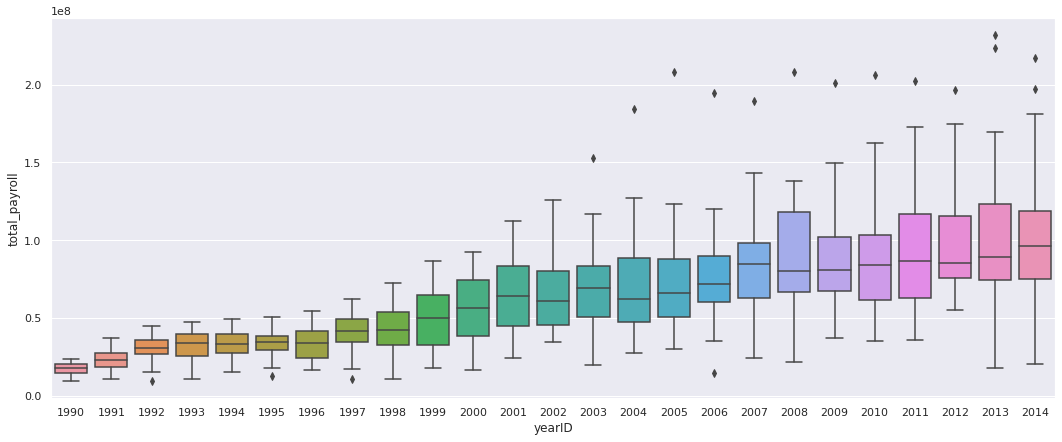

In [7]:
## Part 2: Exploratory Data Analysis
# Problem 2
import seaborn as sns
import matplotlib.pyplot as plt

begin_year = 1990
end_year = 2014
data_range_slice = team_aggregate[(team_aggregate.yearID >= begin_year) & (team_aggregate.yearID <= end_year)]

sns.set(rc={'figure.figsize':(18, 7)})
ax = sns.boxplot(x="yearID", y="total_payroll", data=data_range_slice)

In [8]:
## Part 2: Exploratory Data Analysis
# Question 1 - What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

#The distribution of payrolls overtime has grown increasingly disparate.  While the central tendancy has been growing slowly, the spread has been diverging  rapidly.

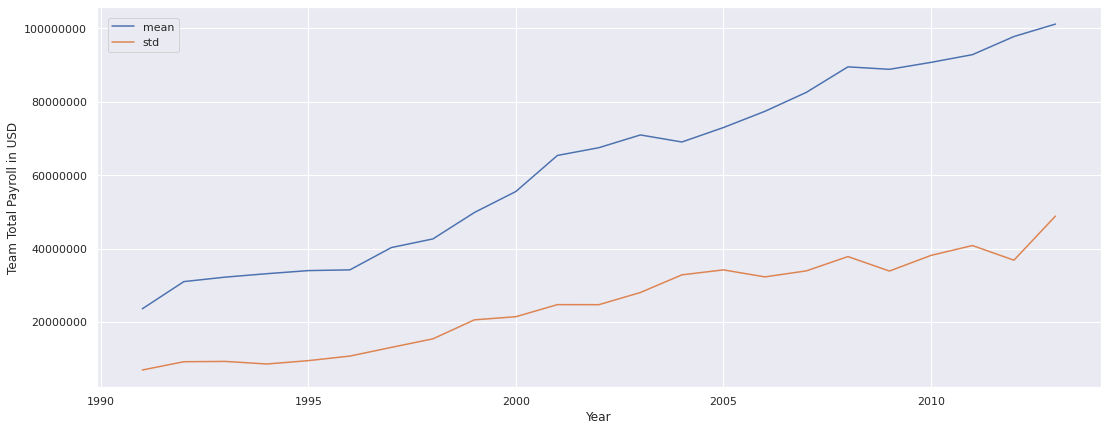

In [9]:
## Part 2: Exploratory Data Analysis
# Problem 3 - Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

import matplotlib.pyplot as plt

begin_year = 1990
end_year = 2014

# Initiate db connection
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query db
salary_query = 'SELECT yearID, teamID, sum(salary) as total_payroll FROM Salaries WHERE yearID > {0} AND yearID < {1} GROUP BY yearID, teamID'.format(begin_year, end_year)
team_salaries = pd.read_sql(salary_query, conn)
conn.close()

# Extract statistics, rename columns
year_stats = pd.DataFrame(team_salaries.groupby('yearID').describe())
year_stats.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Plot
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set(xlabel='Year', ylabel='Team Total Payroll in USD')
plt.plot(year_stats['mean'].index, year_stats['mean'].values, label='mean')
plt.plot(year_stats['std'].index, year_stats['std'].values, label='std')
plt.legend(loc='upper left', borderaxespad=1)

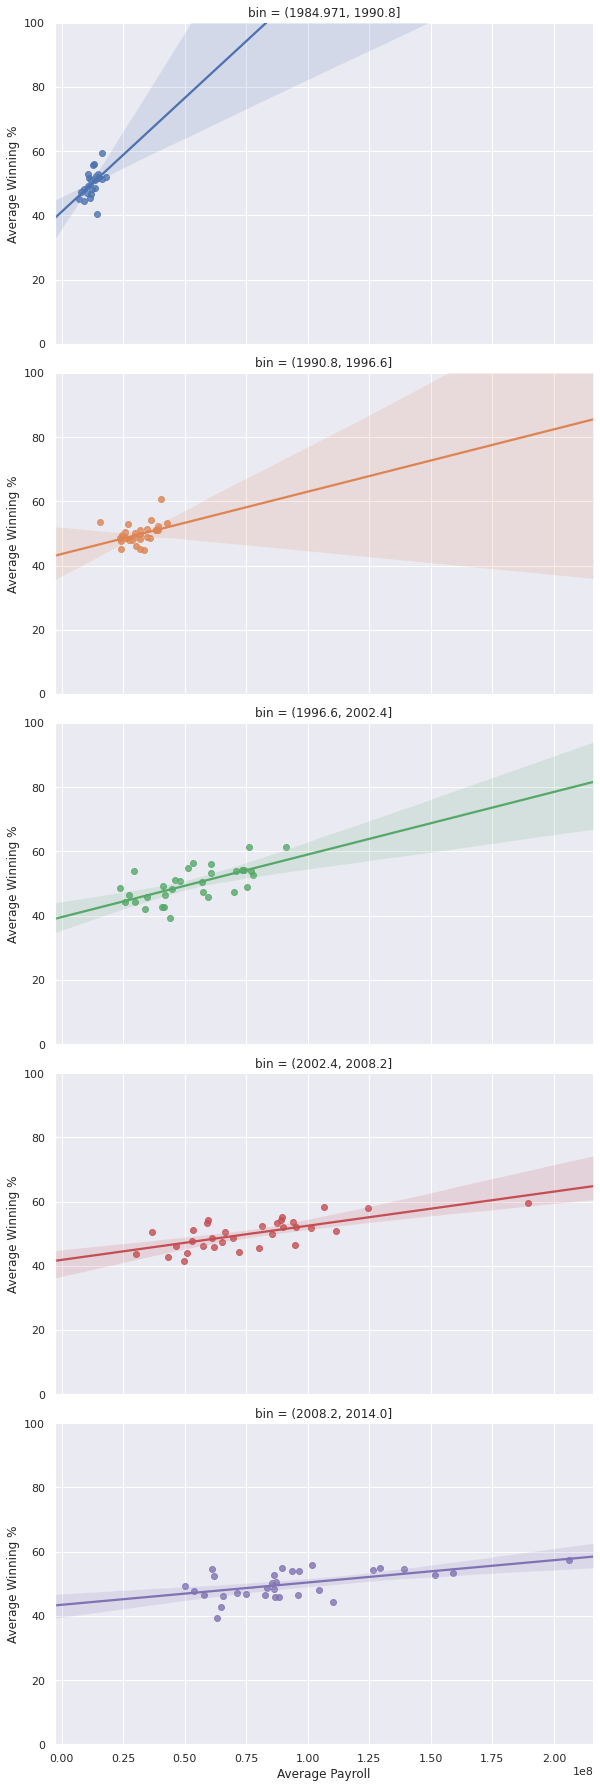

In [79]:
## Part 2: Exploratory Data Analysis
# Problem 4 - Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's polyfit) in each scatter plot to ease interpretation.
import seaborn as sns

# Initiate db connection
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query db
salary_query = 'SELECT yearID, teamID, sum(salary) as total_payroll FROM Salaries GROUP BY yearID, teamID'
team_salaries = pd.read_sql(salary_query, conn)
team_data = pd.read_sql('SELECT yearID, teamID, G, W, L, win_lose_percent FROM Team_Data GROUP BY teamID, yearID', conn)
conn.close()

# Merge DataFrames
team_aggregate = team_data.merge(team_salaries, on=['yearID', 'teamID'])

# Split into year bins
team_aggregate['bin'] = pd.cut(team_aggregate['yearID'], bins=5)

# Create dataframes using List Comprehension which splits groups into list of dataframes 
year_group = pd.DataFrame(team_aggregate.groupby(['bin', 'teamID'])['total_payroll','win_lose_percent'].mean().dropna()).reset_index()
#dfs = [year_group.get_group(year_range) for year_range in year_group.groups]
g = sns.lmplot(x='total_payroll', y='win_lose_percent', col='bin', hue='bin', data=year_group, logistic=False, truncate=False, robust=True, aspect=1.7, col_wrap=1)
g.set_axis_labels("Average Payroll", "Average Winning %")
g.set(ylim=(0, 100))

In [11]:
## Part 2:
# Question 2 - What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

#The payrolls across the periods have grown increasingly large in range, and the gain in winning percentage from increasing payroll has decreased.  You must increase player salaries more, for less winning gain.



In [ ]:
## Part 3: Data transformations
# Standardizing across years - It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

In [104]:
## Part 3
# Problem 5 - Create a new variable in your dataset that standardizes payroll conditioned on year.

# Initiate db connection
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query db
salary_query = 'SELECT yearID, teamID, sum(salary) as total_payroll FROM Salaries GROUP BY yearID, teamID'
team_salaries = pd.read_sql(salary_query, conn)
team_data = pd.read_sql('SELECT yearID, teamID, G, W, L, win_lose_percent FROM Team_Data GROUP BY teamID, yearID', conn)
conn.close()

# Merge DataFrames
team_aggregate = team_data.merge(team_salaries, on=['yearID', 'teamID'])

yearly_payroll_avg = team_salaries.groupby(['yearID'])['total_payroll'].mean()
yearly_payroll_std = team_salaries.groupby(['yearID'])['total_payroll'].std()
#print(type(yearly_payroll_avg))
#print(yearly_payroll_std)

team_aggregate['standardized_payroll'] = team_aggregate.apply(lambda row: (row.total_payroll - yearly_payroll_avg.get(row.yearID)) / yearly_payroll_std.get(row.yearID), axis=1)
team_aggregate.set_index(['yearID', 'teamID']).head(10)

,,G,W,L,win_lose_percent,total_payroll,standardized_payroll
yearID,teamID,,,,,,
1997,ANA,162,84,78,51.851852,31135472.0,-0.698639
1998,ANA,162,85,77,52.469136,41281000.0,-0.086369
1999,ANA,162,70,92,43.209877,55388166.0,0.271410
2000,ANA,162,82,80,50.617284,51464167.0,-0.190214
2001,ANA,162,75,87,46.296296,47535167.0,-0.721244
2002,ANA,162,99,63,61.111111,61721667.0,-0.232769
2003,ANA,162,77,85,47.530864,79031667.0,0.288791
2004,ANA,162,92,70,56.790123,100534667.0,0.960040
1998,ARI,162,65,97,40.123457,32347000.0,-0.667223


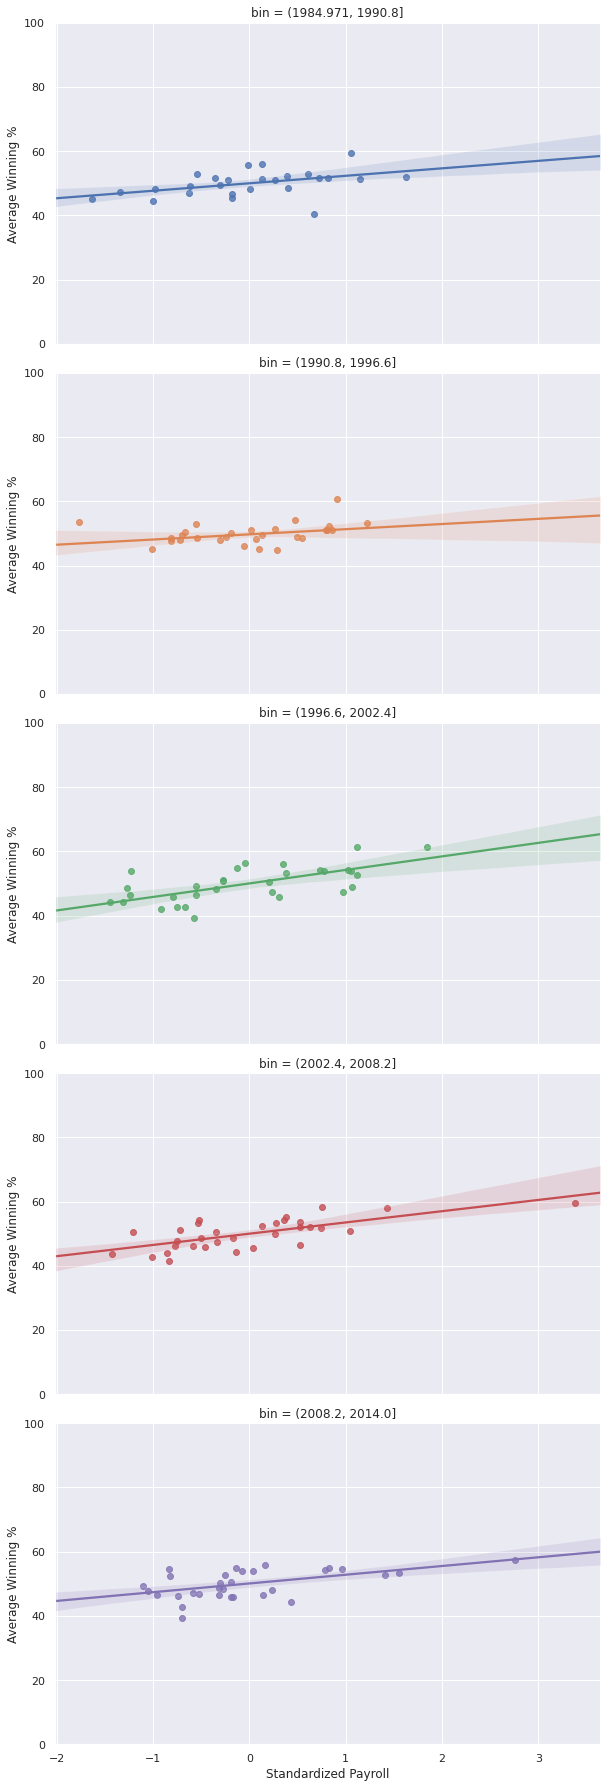

In [105]:
## Part 3
# Problem 6 - Repeat the same plots as Problem 4, but use this new standardized payroll variable.
team_aggregate['bin'] = pd.cut(team_aggregate['yearID'], bins=5)

# Create dataframes using List Comprehension which splits groups into list of dataframes 
year_group = pd.DataFrame(team_aggregate.groupby(['bin', 'teamID'])['standardized_payroll','win_lose_percent'].mean().dropna()).reset_index()
#dfs = [year_group.get_group(year_range) for year_range in year_group.groups]
g = sns.lmplot(x='standardized_payroll', y='win_lose_percent', col='bin', hue='bin', data=year_group, logistic=False, truncate=False, robust=True, aspect=1.7, col_wrap=1)
g.set_axis_labels("Standardized Payroll", "Average Winning %")
g.set(ylim=(0, 100))

In [ ]:
## Part 3
# Question 3 - Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.



In [ ]:
## Part 3
# Problem 7 - Expected wins
# 